# Estrategia sistemática Pablo Patiño




In [1]:
# aquí importo todas las posibles librerias que voy a usar
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from yahoofinancials import YahooFinancials
import yahoo_fin.stock_info as si
import mplfinance as mpf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import statistics
import matplotlib.pyplot as plt
 

In [2]:
# aquí pongo la fecha en la que voy a evaluar la estrategia
start= datetime.datetime(2021,1,1)
end= datetime.datetime(2021,2,28)

In [3]:
#voy a usar las 30 acciones del dow jones para evaluar la estrategia
dow_jones=si.tickers_dow()

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1125)>

**R: For some reason my Jupyter does not read the library si, however, the code above is fine**

In [28]:
# descargo los precios determinados de yahoo finance. Tmbién el s&p500 para las mismas fechas
Data= yf.download(dow_jones, start=start, end=end)
sandp500=yf.download('SPY', start=start, end=end)

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
prices= Data['Adj Close']# selecciono los precios de cierre ajustados para hacer el análisis
syp500=sandp500["Adj Close"]

Para dar un poco de contexto, por un convenio de la universidad estoy viendo un curso de análisis predictivo, en el cual se estudian varios modelos de series de tiempo. Más allá de su uso en la estimación de ciertos tipos de consumo, como gas y energía, yo quería saber si estos modelos tenían un uso más financiero, específicamente, en el campo de la compra y venta de acciones. Para mirar esto, escogí 4 modelos, Simple Expotential Smoothing, Holt, Holt Damped y Arima, de tal modo que cada uno proveerá una señal de posible entrada al mercado. SES asume que no hay estacionalidad ni tendencia, Holt asume solo tendencia, Holt Damped asume una forma específica de la tendencia y Arima asume cuestiones sobre el efecto de los rezagos, la estacionariedad de la serie y el efecto de errores pasados. Cada modelo tiene sus supuestos sobre el comportamiento de la serie de tiempo, así que considero que al usar los 4 se puede eliminar un poco los defectos de cada modelo, de tal modo que el poder predictivo conjunto sea mayor al individual. Para lograr esto se crearon 4 señales con la siguiente lógica: 
si tengo 100 datos dejo los primeros 10, en mi caso, o el número que sea, como datos de aprendizaje, ya que estos modelos se comportan mejor cuando tienen mucha información, ya que pueden aprender sobre la tendencia y patrones recurrentes en el precio. Lo siguiente es que cada día, haciendo uso únicamente del precio de ese día y de días pasados, se estima el precio de los siguientes 3 días. A esas estimaciones se les saca el promedio, y si son mayores al promedio del precio del día presente y los últimos 2 días, multiplicado por (1+p), donde "p" es un porcentaje de incremento, entonces se interpreta que se debe entrar al mercado. Los 3 días, aunque arbitrarios, se explican mediante la naturaleza de estos modelos, ya que son más precisos en el corto plazo, por lo que estimar a 3 días es lo apropiado. El promedio de 3 días del precio es porque interesa el comportamiento de los precios en un intervalo pequeño de tiempo. Se pudo haber escogido un ewma o cualquier otro tipo de promedio ponderado, pero yo escogí usar el promedio simple de 3 días. Como mi objetivo es mirar que tan útiles son estos modelos, la señal de salida dependerá únicamente de las señales previamente mencionadas, ya que el uso de cualquier otro tipo de señal de salida supondría un análisis adicional, lo que quitaría el sentido a lo que estoy intentando hacer. Ejemplo de ello es que inicialmente pensé en usar un stoploss, pero me di cuenta de que, al hacerlo, aun si protegía mi inversión, estaría obteniendo resultados inconclusos, ya que, si se tuvo que usar tal salida, es porque el modelo no pudo pronosticar correctamente tal caída en el precio. Soy consciente de que en este sentido la estrategia es vulnerable a cambios súbitos en el precio que no puedan ser modelados estadísticamente, pero si no es así, no puedo comprobar la extensión de los conocimientos adquiridos en ese curso. Ahora bien, mi estrategia de salida tampoco es que sea mediocre. Esta consistirá que en cuento las señales de entrada, en su mayoría, sean 0, salgo del mercado. Esto quiere decir que por lo menos 3 de los 4 modelos pronostican que el precio promedio de los próximos 3 días será inferior al (1+p) por el promedio de 3 días, lo que puede ser sinónimo de cambios en la tendencia de corto plazo, o que simplemente no hay la suficiente certeza de que va a aumentar el precio. Teniendo en cuenta ambas señales de entrada y salida, a menos que haya tendencias muy bien marcadas, yo no debería estar en posesión de una acción mucho tiempo. Otro aspecto a considerar es que, si estoy en posesión de la acción, voy a aumentar mi posición según indiquen las señales, es decir, si un día tengo 1 y me dicen que compre 2, entonces tengo 3. La señal de salida aplica a todas las acciones de X compañía en mi posesión. Otra aclaración es que si se activan 2 señales no compro nada, si se estivan 3 señales, compro 80 acciones, y si se activan las 4, compro 100. En conclusión, tanto la salida como entrada dependen de las señales de entrada, lo que me permitirá evaluar la capacidad de 4 modelos estadísticos en el campo financiero. Cabe aclarar que tanto la compra y venta de las acciones va con un lag de un día, ya que el ejercicio se realizó con los precios de cierre ajustados.
 

**R: The strategy seems very interesting. Usually you do not use the average of the three days because of how you are constructing your exit strategies for instance if the price of day one is forecasted to be 100 on day 2 zero and on day 3 zero your forecast is 33.3, if the price of today is 20 you would probably go in but it would not be wise, you what you usually do is to forecast the day that you will try to get out. With that said, your strategy has a nice logic and it is quite interesting**

In [7]:
# aca hago el pronóstico a 3 días con el modelo SES. Por definición estos pronósticos son iguales, así que da igual si se pronóstica un solo día
# como mencioné, hay una cantidad arbitraria de días de aprendizaje, por lo tanto, la señal es 0. Se repite en las otras
# 3 señales
def SES(base,ce=0.01):
    ses=pd.DataFrame(index=base.index,columns=base.columns)
    ses.columns=["s"]
    sbase=base.copy(deep=True)
    sbase.reset_index(drop=True, inplace=True)
    for i in range(0,len(base)):
        if i<=10:
            ses.iloc[i]=0
        else:
            aux=sbase.loc[:i]
            mod=SimpleExpSmoothing(aux).fit().forecast(3)
            ses.iloc[i]=np.mean(mod)
    return ses
        
    
        
        

In [8]:
# promedio pronóstico a 3 días de Holt. La función optimiza las parametros automaticamente si uno no los pone (mi caso)
def holt(base):
    sus=pd.DataFrame(index=base.index,columns=base.columns)
    sus.columns=["h"]
#sus.rename(columns={"AAPL":"holt"})
    sbase=base.copy(deep=True)
    sbase.reset_index(drop=True, inplace=True)
    for i in range(0,len(base)):
        if i<=10:
            sus.iloc[i]=0
        else:
            aux=sbase.loc[:i]
            mod=ExponentialSmoothing(aux,trend="add",damped_trend=False,seasonal=None).fit().forecast(3)
            sus.iloc[i]=np.mean(mod)
        
    return sus
    

In [9]:
# promedio pronóstico a 3 días de Holt Damped. La función optimiza las parametros automaticamente si uno no los pone (mi caso)
def holtd(base):
    sas=pd.DataFrame(index=base.index,columns=base.columns)
    sas.columns=["hd"]
    sbase=base.copy(deep=True)
    sbase.reset_index(drop=True, inplace=True)
    for i in range(0,len(base)):
        if i<=10:
            sas.iloc[i]=0
        else:
            aux=sbase.loc[:i]
            mod=ExponentialSmoothing(aux,trend="add",damped_trend=True,seasonal=None).fit().forecast(3)
            sas.iloc[i]=np.mean(mod)
    return sas
    

In [10]:
# promedio pronóstico a 3 días.Normalmente en un Arima toca específicar 3 hiperparámetros, pero esta función que estoy 
# usando acá permite que estos se optimicen automaticamente, como suele suceder en R. La desventaja es que toma bastante
# tiempo, por lo que la demostración no se hará en muchos valores, pues tardaría horas en realizar los pronósrticos.
def arima(base):
    sos=pd.DataFrame(index=base.index,columns=base.columns)
    sos.columns=["arm"]
    sbase=base.copy(deep=True)
    sbase.reset_index(drop=True, inplace=True)
    for i in range(0,len(base)):
        if i<=10:
            sos.iloc[i]=0
        else:
            aux=sbase.loc[:i]
            mod=auto_arima(aux,supress_warnings=True,stepwise=True).fit(aux).predict(3)
            sos.iloc[i]=np.mean(mod)
    return sos



In [11]:
# creación de la variable binaria. 1 si se cumple la señal de entrada de SES  y 0 en caso contrario. Por default el porcentaje
# de incremento es 1%, pero puede modificarse.
def smooth(base,ce=0.01):
    mat1=pd.DataFrame(index=base.index,columns=base.columns)
    mat1.columns=["señal_ses"]
    aja=SES(base)
    for i in range(len(base)):
        if i<=10:
            mat1.iloc[i]=0
        else:
            if np.array(aja.iloc[i])>((1+ce)*np.mean(np.array(base.iloc[i-2:i+1]))):
                mat1.iloc[i]=1
            else:
                mat1.iloc[i]=0
    return mat1
                    
            
            
        

**R: Nice code, makes sense. Please disregard what I mentioned above, I hadn't understood the strategy then**

In [12]:
# creación de la variable binaria. 1 si se cumple la señal de entrada de Holt  y 0 en caso contrario. Por default el porcentaje
# de incremento es 1%, pero puede modificarse.
def ht(base,ce=0.01):
    mat2=pd.DataFrame(index=base.index,columns=base.columns)
    mat2.columns=["señal_holt"]
    eje=holt(base)
    for i in range(len(base)):
        if i<=10:
            mat2.iloc[i]=0
        else:
            if np.array(eje.iloc[i])>((1+ce)*np.mean(np.array(base.iloc[i-2:i+1]))):
                mat2.iloc[i]=1
            else:
                mat2.iloc[i]=0
    return mat2

In [13]:
# creación de la variable binaria. 1 si se cumple la señal de entrada de Holt Damped  y 0 en caso contrario. Por default el porcentaje
# de incremento es 1%, pero puede modificarse.
def htd(base,ce=0.01):
    mat3=pd.DataFrame(index=base.index,columns=base.columns)
    mat3.columns=["señal_holt_damped"]
    iji=holtd(base)
    for i in range(len(base)):
        if i<=10:
            mat3.iloc[i]=0
        else:
            if np.array(iji.iloc[i])>((1+ce)*np.mean(np.array(base.iloc[i-2:i+1]))):
                mat3.iloc[i]=1
            else:
                mat3.iloc[i]=0
    return mat3

In [14]:
# creación de la variable binaria. 1 si se cumple la señal de entrada de Arima  y 0 en caso contrario. Por default el porcentaje
# de incremento es 1%, pero puede modificarse.
def ari(base,ce=0.01):
    mat4=pd.DataFrame(index=base.index,columns=base.columns)
    mat4.columns=["señal_arima"]
    ojo=arima(base)
    for i in range(len(base)):
        if i<=10:
            mat4.iloc[i]=0
        else:
            if np.array(ojo.iloc[i])>((1+ce)*np.mean(np.array(base.iloc[i-2:i+1]))):
                mat4.iloc[i]=1
            else:
                mat4.iloc[i]=0
    return mat4

In [31]:
# suma de las señales cada día. Compro 80 si se activan 3, 100 si se activan 4 y 0 de lo contrario.
def señal_total(base):
    bas=pd.DataFrame(index=base.index,columns=base.columns)
    bas.columns=["tot_señal"]
    se=smooth(base)
    hl=ht(base)
    hld=htd(base)
    ar=ari(base)
    for i in range(len(base)):
        if sum([np.array(se.iloc[i]),np.array(hl.iloc[i]),np.array(hld.iloc[i]),np.array(ar.iloc[i])])<=2:
            bas.iloc[i]=0
        if sum([np.array(se.iloc[i]),np.array(hl.iloc[i]),np.array(hld.iloc[i]),np.array(ar.iloc[i])])==3:
            bas.iloc[i]=80
        if sum([np.array(se.iloc[i]),np.array(hl.iloc[i]),np.array(hld.iloc[i]),np.array(ar.iloc[i])])==4:
            bas.iloc[i]=100
    se_t=pd.concat([se,hl,hld,ar,bas],axis=1)
        
    return se_t
            
    

In [16]:
# muestra en el día cuantas acciones voy a comprar
def cantidad_comprar(base):
    iyi=pd.DataFrame(index=base.index,columns=base.columns)
    iyi.columns=["cantidad_compra"]
    st=señal_total(base)
    for i in range(len(base)):
        if i<=10:
            iyi.iloc[i]=0
        else:
            if np.array(st["tot_señal"].iloc[i-1])==0:
                iyi.iloc[i]=0
            if np.array(st["tot_señal"].iloc[i-1])!=0:
                iyi.iloc[i]=st["tot_señal"].iloc[i-1]
    kasu=pd.concat([st,iyi],axis=1)
    return kasu

    

In [17]:
# muestra en el día cuantas acciones tengo
def propiedad(base):
    uyu=pd.DataFrame(index=base.index,columns=base.columns)
    uyu.columns=["inventario"]
    fa=cantidad_comprar(base)
    for i in range(len(base)):
        if i==0:
            uyu.iloc[i]=0
        else:
            if fa["tot_señal"].iloc[i-1]==0:
                uyu.iloc[i]=0
            else:
                uyu.iloc[i]=uyu.iloc[i-1]+fa["cantidad_compra"].iloc[i]
    qqq=pd.concat([fa,uyu],axis=1)
    return qqq
    
    

In [18]:
# muestra cuantas acciones debo vender en el día
def cantidad_vender(base):
    inte=pd.DataFrame(index=base.index,columns=base.columns)
    inte.columns=["venta"]
    wa=propiedad(base)
    for i in range(len(base)):
        if i==0:
            inte.iloc[i]=0
        else:
            if wa["inventario"].iloc[i]==0:
                inte.iloc[i]=wa["inventario"].iloc[i-1]
            else:
                inte.iloc[i]=0
    tt=pd.concat([wa,inte],axis=1)
    return tt
    

In [19]:
# cuanto dinero en efectivo tengo. por cada acción, tengo 1000000 dólares. Es posible endeudarse a tasa 0.
# asumo costos transaccionales de 10 pb. Puede modificarse
def efectivo(base,com_c=1/1000,com_v=1/1000,dinero=100000):
    efe=pd.DataFrame(index=base.index,columns=base.columns)
    efe.columns=["dinero"]
    total=cantidad_vender(base)
    for i in range(len(base)):
        if i==0:
            efe.iloc[i]=dinero
        else:
            efe.iloc[i]=(np.array(efe.iloc[i-1]))-((1+com_c)*np.array(base.iloc[i])*np.array(total["cantidad_compra"].iloc[i]))+((1-com_v)*np.array(base.iloc[i])*np.array(total["venta"].iloc[i]))
    gea=pd.concat([base,total,efe],axis=1)
    return gea
    

In [20]:
# cuanto valen las acciones en mi posesion determinado día.
def valor_inventario(base):
    vi=pd.DataFrame(index=base.index,columns=base.columns)
    vi.columns=["valor_acciones"]
    ñam=efectivo(base)
    for i in range(len(base)):
        vi.iloc[i]=np.array(base.iloc[i])*np.array(ñam["inventario"].iloc[i])
    ha=pd.concat([ñam,vi],axis=1)
    return ha

    

In [21]:
# suma del efectivo y valor de las acciones en un determinado día
def portafolio(base):
    port=pd.DataFrame(index=base.index,columns=base.columns)
    port.columns=["valor portafolio"]
    xaka=valor_inventario(base)
    for i in range(len(base)):
        port.iloc[i]=np.array(xaka["dinero"].iloc[i])+np.array(xaka["valor_acciones"].iloc[i])
    vy=pd.concat([xaka,port],axis=1)
    return vy

In [22]:
# muestra total del portafolio
def total(datos,tickers):
    a=[]
    b=pd.DataFrame(a,index=tickers)
    mun=pd.DataFrame(index=datos.index)
    mon=pd.DataFrame(index=datos.index,columns=["PORTAFOLIO"])
    for i in range(len(tickers)):
        p=portafolio(pd.DataFrame(datos.iloc[:,i]))
        cafir=p["valor portafolio"]
        mun=pd.concat([mun,cafir],axis=1)
    for i in range(len(datos)):
        mon.iloc[i]=sum(mun.iloc[i,:])
    return mon
        
        

In [23]:
def peak(base):
    pk=pd.DataFrame(index=base.index,columns=["peak"])
    for i in range(len(base)):
        if i==0:
            pk.iloc[i]=base.iloc[i]
        else:
            if np.array(base.iloc[i])>np.array(pk.iloc[i-1]):
                pk.iloc[i]=base.iloc[i]
            else:
                pk.iloc[i]=pk.iloc[i-1]
    return pk

In [24]:
# comparo entre mi estrategia y un portafolio de 3 millones de dólares que invierte todo, en el día 12, en el s&p500. No vende.
def com_pablo_500(datos,base500,tickers,cc=1/1000):
    porta=total(datos,tickers)
    fal=pd.DataFrame(index=base500.index,columns=["p_s&p500"])
    for i in range(len(base500)):
        if i<=10:
            fal.iloc[i]=3000000
        else:
            ci=3000000/(np.array(base500.iloc[11])*(1+cc))
            fal.iloc[i]=ci*base500.iloc[i]
    
    rsyp=float(100*(np.array(fal.iloc[-1])-np.array(fal.iloc[0]))/np.array(fal.iloc[0]))
    reto=pd.DataFrame(index=base500.index,columns=["returns"])
    for i in range(len(base500)):
        if i==0:
            reto.iloc[i]=0
        else:
            reto.iloc[i]=(np.array(fal.iloc[i])-np.array(fal.iloc[i-1]))/(np.array(fal.iloc[i-1]))
    r500=100*statistics.mean(reto["returns"].iloc[1:])
    v500=100*statistics.stdev(reto["returns"].iloc[1:])
    peak500=peak(pd.DataFrame(fal))
    draw500=pd.DataFrame(index=fal.index,columns=["drawdown500"])
    for i in range(len(draw500)):
        if i==0:
            draw500.iloc[i]=0
        else:
            draw500.iloc[i]=100*(np.array(peak500.iloc[i])-np.array(fal.iloc[i]))/np.array(peak500.iloc[i])
    maxdr500=float(np.array(draw500.max(axis=0)))
    cr500=rsyp/maxdr500
    print("el max drawdown del s&p500 es:",maxdr500,"%")
    print("la rentabilidad diaria promedio del s&p500 es:",r500,"%")
    print("la rentabilidad del s&p500 en el periodo analizado fue:",rsyp,"%")
    print("la volatilidad de los retornos del s&p500 es:",v500,"%")
    print("como los rendimientos no están anualizados, una aproximación al calmar ratio es:",cr500)
    zam=pd.DataFrame(index=porta.index,columns=["retornos"])
    for i in range(len(zam)):
        if i==0:
            zam.iloc[i]=0
        else:
            zam.iloc[i]=(np.array(porta.iloc[i])-np.array(porta.iloc[i-1]))/(np.array(porta.iloc[i-1]))
    pqs=pd.concat([porta,zam],axis=1)
    pea=peak(pd.DataFrame(porta))
    draw=pd.DataFrame(index=porta.index,columns=["drawdown"])
    for i in range(len(draw)):
        if i==0:
            draw.iloc[i]=0
        else:
            draw.iloc[i]=100*(np.array(pea.iloc[i])-np.array(porta.iloc[i]))/np.array(pea.iloc[i])
    maxdr=float(np.array(draw.max(axis=0)))
    hh=pd.concat([pqs,pea,draw],axis=1)
    ren=float(100*(np.array(porta.iloc[-1])-np.array(porta.iloc[0]))/(np.array(porta.iloc[0])))
    rentp=float(sum(np.array(zam))/(len(zam)-1)*100)
    vol=100*statistics.stdev(zam["retornos"].iloc[1:])
    cr=ren/maxdr
    
    print("el max drawdown del portafolio es:",maxdr,"%")
    print("la rentabilidad diaria promedio del portafolio es:",rentp,"%")
    print("la rentabilidad del portafolio en el periodo analizado fue:",ren,"%")
    print("la volatilidad de los retornos de la estrategia es:",vol,"%")
    print("como no hay una temporalidad fija, no es correcto cslcular el sharp ratio,pues varía la tasa libre de riesgo, sin embargo, es negativo")
    print("como los rendimientos no están anualizados, una aproximación al calmar ratio es:",cr)
   
    eureca=pd.concat([porta,fal],axis=1)
    
    fig, ax = plt.subplots()
    ax =eureca.plot(ax=ax)



    
    return eureca



            

el max drawdown del s&p500 es: 3.7253902679667785 %
la rentabilidad diaria promedio del s&p500 es: -0.02410740317448356 %
la rentabilidad del s&p500 en el periodo analizado fue: -1.01852782865994 %
la volatilidad de los retornos de la estrategia es: 0.852389222012809 %
como los rendimientos no están anualizados, una aproximación al calmar ratio es: -0.2734016453035472
el max drawdown del portafolio es: 0.5105843795089827 %
la rentabilidad diaria promedio del portafolio es: -0.013812736834026139 %
la rentabilidad del portafolio en el periodo analizado fue: -0.5105843795089827 %
la volatilidad de los retornos de la estrategia es: 0.0660355956568585 %
como no hay una temporalidad fija, no es correcto cslcular el sharp ratio,pues varía la tasa libre de riesgo, sin embargo, es negativo
como los rendimientos no están anualizados, una aproximación al calmar ratio es: -1.0


,PORTAFOLIO,p_s&p500
Date,,
2021-01-04,3000000.0,3000000
2021-01-05,3000000.0,3000000
2021-01-06,3000000.0,3000000
2021-01-07,3000000.0,3000000
2021-01-08,3000000.0,3000000
2021-01-11,3000000.0,3000000
2021-01-12,3000000.0,3000000
2021-01-13,3000000.0,3000000
2021-01-14,3000000.0,3000000


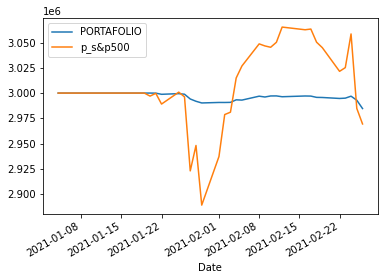

In [33]:
# resumen de la comparación
com_pablo_500(prices,syp500,dow_jones)

# Aclaraciones y comentarios finales
Para aclarar, en mi portafolio asumí que para cada acción hay un presupuesto inicial de 100000 dólares, y como en el dow jones hay 30 acciones, mi portafolio tiene inicialmente 3 millones de dólares en efectivo. Es posible endeudarse para comprar acciones, y por simplicidad, la deuda no paga intereses. Para compararlo con el rendimiento del s&p500, asumí que en el día 12 invertí 3 millones de dólares en el índice. La posición nunca la vendo, y tengo en cuesta los costos transaccionales (10 pb) para la primera compra. Como el auto arima se demora tanto, comparí mi estrategia con el s&p500 en los 2 primeros meses del año. Aunque resultó perdedora, no perdí tanto como el mercado, aunque quizás esto se deba a que no estaba tan expuesto, ya que máximo compraba 100 acciones al día.Si se cambia la posición dependiendo de la señal, seguramente o gane un poco más, o pierda un poco más.

**R: It was a very nice strategy, the code seems clean and the logic was great. You did calculate the risk return measures correctly, for the future, you might want to use the risk free rate for each day so your results are more robust. Your problems are: You only tested the strategy for one month, thus, you cannot conclude whether the strategy works or not. You should use more data (five years) and see how your strategy does, to see if you can use it for trading in the future**